# Imports

In [1]:
import torch
import torchvision
import torch.utils.tensorboard as tb
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import math
from skimage import io, transform
import torch.nn as nn
from os import path
import torchtext
import torchvision.models as models
import torch.optim as optim
import cv2

# Clean Dataset

In [2]:
import os
import tarfile
 
def removeFile(filename):
  prefix, ext = os.path.splitext(filename)
  newFilename = 'crop_part1_clean.tar.gz'
  original = tarfile.open(filename)
  modified = tarfile.open(newFilename, 'w')
  for info in original.getmembers():
    try:
      ethnicity = info.name.replace('crop_part1/', '').split('_')[2]
    except:
      continue
      
    if ethnicity != '0' and ethnicity != '1' and ethnicity != '2' and ethnicity != '3' and ethnicity != '4':
      print(info.name)
      continue
    else:
      extracted = original.extractfile(info)
      modified.addfile(info, extracted)
  original.close()
  modified.close()

removeFile('/content/crop_part1.tar.gz')

crop_part1/61_3_20170109150557335.jpg.chip.jpg
crop_part1/61_1_20170109142408075.jpg.chip.jpg


# Loading Data

In [3]:
class FaceDataset(Dataset):
    """Facial recognition dataset."""

    def __init__(self, root_dir, transform=None):
      self.info =  torchtext.utils.extract_archive(root_dir)
      self.root_dir = root_dir
      self.transform = transform

    def __len__(self):
      return len(self.info)

    def __getitem__(self, idx):
      if torch.is_tensor(idx):
        idx = idx.tolist()

      file = self.info[idx]
      image = io.imread(file)
      image = cv2.resize(image, (64, 64))
      image = transforms.ToTensor()(image)
      # The labels of each face image is embedded in the file name, formated like [age]_[gender]_[race]_[date&time].jpg
      age = int(file.replace('/content/crop_part1/', '').split('_')[0])
      gender = int(file.replace('/content/crop_part1/', '').split('_')[1])
      ethnicity = int(file.replace('/content/crop_part1/', '').split('_')[2])

      if self.transform:
        image = self.transform(image)
      
      return (image, torch.tensor(ethnicity))

In [4]:
path = '/content/crop_part1_clean.tar.gz'

data_transform = transforms.Compose([
      transforms.RandomHorizontalFlip(p=0.3),
      transforms.RandomVerticalFlip(p=.3),
      transforms.RandomPerspective(distortion_scale=0.2, p=.3, interpolation=torchvision.transforms.InterpolationMode.NEAREST, fill=0),
      transforms.RandomRotation(degrees = 30),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])

data = FaceDataset(path, transform=transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]))
augmented_data = FaceDataset(path, transform=data_transform)
# increase the size of training data with image augmentation
combined_data = torch.utils.data.ConcatDataset([augmented_data, data])

0 torch.Size([3, 64, 64])


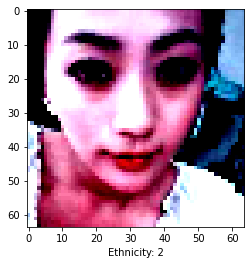

1 torch.Size([3, 64, 64])


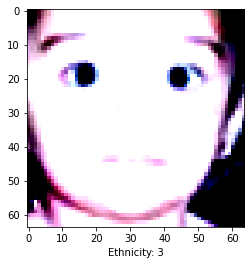

2 torch.Size([3, 64, 64])


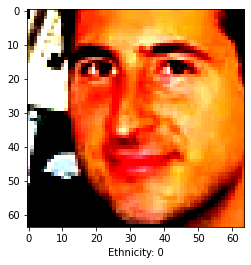

In [5]:
# non augmented images
for i in range(3):
    sample = data[i]

    print(i, sample[0].shape)
    plt.xlabel("Ethnicity: {}".format(sample[1]))
    plt.imshow(sample[0].permute(1, 2, 0).numpy())
    plt.show()

0 torch.Size([3, 64, 64])


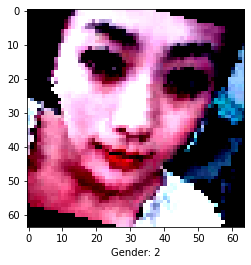

1 torch.Size([3, 64, 64])


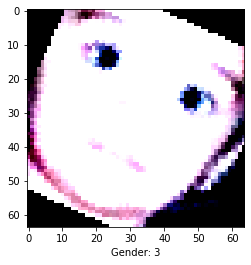

2 torch.Size([3, 64, 64])


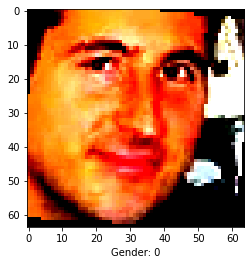

In [ ]:
# augmented images
for i in range(3):
  sample = augmented_data[i]

  print(i, sample[0].shape)
  plt.xlabel("Gender: {}".format(sample[1]))
  plt.imshow(sample[0].permute(1, 2, 0).numpy())
  plt.show()

In [6]:
dataset_size = len(combined_data)
train_size = int(dataset_size * 0.8)
test_size = dataset_size - train_size

final_train_size = int(train_size * 0.75)
valid_size = train_size - final_train_size

train_data, test = torch.utils.data.random_split(combined_data, [train_size, test_size])
train_data, valid = torch.utils.data.random_split(train_data, [final_train_size, valid_size])

In [7]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=2, shuffle=True)
valid_loader = DataLoader(valid, batch_size=batch_size, num_workers=2, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, num_workers=2, shuffle=True)

# Utility Functions

In [8]:
def init_weights(net):
  for m in net.modules():
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

In [9]:
import torchvision.models as models
import torch.optim as optim


def train(args, save=False):
    device = torch.device("cuda")
    model = args.model.to(device)
    model.train()
    optimizer = optim.Adam(params=model.parameters(), lr=args.learning_rate, weight_decay=args.regularization, amsgrad=False)
    # optimizer = optim.SGD(params=model.parameters(), lr=args.learning_rate, weight_decay=args.regularization)
    criterion = torch.nn.CrossEntropyLoss()
    train_loader, valid_loader = args.train, args.valid 
    scheduler = optim.lr_scheduler.StepLR(optimizer, args.step, gamma=0.1, last_epoch=-1, verbose=True)

    if args.init_weight:
      model.apply(init_weights)

    train_loss_hist = []
    valid_loss_hist = []
    train_accuracy_hist = []
    valid_accuracy_hist = []

    for epoch in range(args.epochs):  # loop over the dataset multiple times
      model.train()
      train_loss = 0.0
      valid_loss = 0.0
      train_accuracy = 0.0
      valid_accuracy = 0.0
      total1, total2 = 0, 0

      for i, data in enumerate(train_loader, 1):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        # zero the parameter gradients
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        
        # forward + backward + optimize
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_accuracy += (predicted == labels).float().sum() 
        total1 += inputs.size(0)


      for j, data in enumerate(valid_loader, 1):
        model.eval()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        valid_loss += (loss.item() * inputs.size(0))
        _, predicted = torch.max(outputs.data, 1)
        valid_accuracy += (predicted == labels).float().sum() 
        total2 += inputs.size(0)
      
      scheduler.step()
      train_loss = train_loss/total1
      valid_loss = valid_loss/total2
      train_accuracy = train_accuracy/total1
      valid_accuracy = valid_accuracy/total2
      
      train_loss_hist.append(train_loss)
      valid_loss_hist.append(valid_loss)
      train_accuracy_hist.append(train_accuracy)
      valid_accuracy_hist.append(valid_accuracy)
      print("Training Loss: {} Valid Loss: {} Training Accuracy: {} Valid Accuracy: {}"
      .format(train_loss, valid_loss, train_accuracy, valid_accuracy))
    
    if save:
      torch.save(model, 'model')

    return (train_loss_hist, valid_loss_hist, train_accuracy_hist, valid_accuracy_hist)

In [10]:
def graph_train_valid(train_data, valid_data, title, num):
  epochs = len(train_data)
  plt.plot(range(epochs), train_data, label="training {}".format(title))
  plt.plot(range(epochs), valid_data, label = 'validation {}'.format(title))
  plt.title('Ethnicity Model{} {}'.format(num, title))
  plt.xlabel("epochs")
  plt.ylabel(title)
  plt.legend()
  plt.show()

In [11]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time

def final_score(model, device, test_loader):
  model = model.to(device)
  model.eval()
  preds = []
  true = []
  start =  time.time()

  for i, data in enumerate(test_loader):
    inputs, labels = data 
    inputs = inputs.to(device)
    size = inputs.size(0)
    pred = torch.argmax(model(inputs), dim = 1).tolist()
    pred = map(int, pred)
    preds.extend(list(pred))
    true.extend(labels.tolist())

  precision = precision_score(true, preds, average='weighted')
  recall = recall_score(true, preds, average='weighted')
  f1 = f1_score(true, preds, average='weighted')

  cm = confusion_matrix(true, preds)
  df_cm = pd.DataFrame(cm, range(5), range(5))
  sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
  plt.show()

  end = time.time()

  return precision, recall, f1, (end-start)

# Baseline CNN Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class EthnicityCNN1(torch.nn.Module):
    def __init__(self):
      super(EthnicityCNN1, self).__init__() 
      self.dropout = nn.Dropout(.25)
      self.pool = nn.MaxPool2d((2, 2), (2, 2))

      self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=4, stride=1)
      self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2)
      self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=1)
      self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2)

      self.bn1 = nn.BatchNorm2d(num_features=16)
      self.bn2 = nn.BatchNorm2d(num_features=32)
      self.bn3 = nn.BatchNorm2d(num_features=64)
      self.bn4 = nn.BatchNorm2d(num_features=64)

      self.fc1 = nn.Linear(in_features=9216, out_features=256)
      self.fc2 = nn.Linear(in_features=256, out_features=128)
      self.fc3 = nn.Linear(in_features=128, out_features=5)

    def forward(self, x):
      x = F.relu(self.bn1(self.conv1(x)))
      x = self.dropout(F.relu(self.bn2(self.conv2(x))))
      x = F.relu(self.bn3(self.conv3(x)))
      x = self.dropout(F.relu(self.bn4(self.conv4(x))))
    
      x = torch.flatten(x, 1)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)

      return x
      

device = torch.device("cuda")
model = EthnicityCNN1()
summary(model.to(device), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 61, 61]             784
       BatchNorm2d-2           [-1, 16, 61, 61]              32
            Conv2d-3           [-1, 32, 29, 29]           8,224
       BatchNorm2d-4           [-1, 32, 29, 29]              64
           Dropout-5           [-1, 32, 29, 29]               0
            Conv2d-6           [-1, 64, 26, 26]          32,832
       BatchNorm2d-7           [-1, 64, 26, 26]             128
            Conv2d-8           [-1, 64, 12, 12]          65,600
       BatchNorm2d-9           [-1, 64, 12, 12]             128
          Dropout-10           [-1, 64, 12, 12]               0
           Linear-11                  [-1, 256]       2,359,552
           Linear-12                  [-1, 128]          32,896
           Linear-13                    [-1, 5]             645
Total params: 2,500,885
Trainable param

In [ ]:
class Args(object):
    pass

args1 = Args()
args1.learning_rate = .005
args1.regularization = 5e-4

args1.model = EthnicityCNN1()
args1.train = train_loader
args1.valid = valid_loader 
args1.epochs = 15
args1.init_weight = True
args1.step = 5

train_loss1, valid_loss1, train_accuracy1, valid_accuracy1, = train(args1)

Adjusting learning rate of group 0 to 5.0000e-03.
Adjusting learning rate of group 0 to 5.0000e-03.
Training Loss: 1.6828843489851903 Valid Loss: 1.1128002701589623 Training Accuracy: 0.5203272700309753 Valid Accuracy: 0.5747890472412109
Adjusting learning rate of group 0 to 5.0000e-03.
Training Loss: 1.0601773854158707 Valid Loss: 1.0095513752356602 Training Accuracy: 0.5984829068183899 Valid Accuracy: 0.6272053122520447
Adjusting learning rate of group 0 to 5.0000e-03.
Training Loss: 0.9691811926497184 Valid Loss: 0.9396516820470624 Training Accuracy: 0.6360692381858826 Valid Accuracy: 0.6540526747703552
Adjusting learning rate of group 0 to 5.0000e-03.
Training Loss: 0.9096737823136412 Valid Loss: 0.937003358646111 Training Accuracy: 0.6622347235679626 Valid Accuracy: 0.6632574796676636
Adjusting learning rate of group 0 to 5.0000e-04.
Training Loss: 0.8530381166405622 Valid Loss: 0.8140149802937284 Training Accuracy: 0.6796215772628784 Valid Accuracy: 0.6952186226844788
Adjusting l

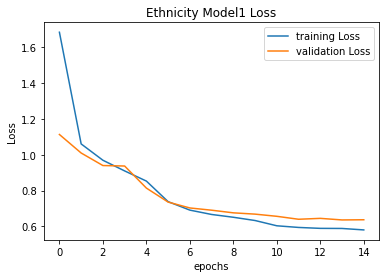

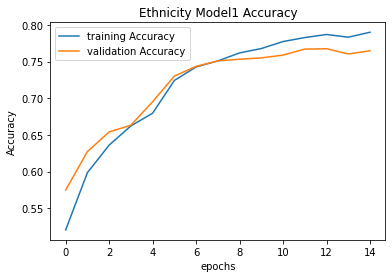

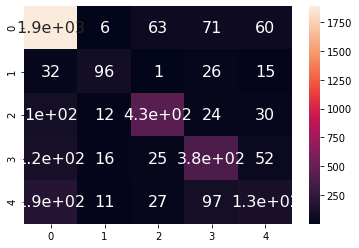

Test Precision: 0.732385792630969 Test Recall: 0.748721881390593 Test F1: 0.7364586097981264 Total Time: 6.141439199447632 seconds


In [ ]:
graph_train_valid(train_loss1, valid_loss1, 'Loss', 1)
graph_train_valid(train_accuracy1, valid_accuracy1, 'Accuracy', 1)
precision1, recall1, f1_1, time1 = final_score(args1.model, device, test_loader)
print("Test Precision: {} Test Recall: {} Test F1: {} Total Time: {} seconds".format(precision1, recall1, f1_1, time1))

CNN Model #2

In [ ]:
class EthnicityCNN2(torch.nn.Module):
    def __init__(self):
      super(EthnicityCNN2, self).__init__() 
      self.dropout = nn.Dropout(.25)
      self.pool1 = nn.MaxPool2d((2, 2), stride=2)
      self.pool2 = nn.MaxPool2d((2, 2))

      self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=1)
      self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=1)
      self.conv3 = nn.Conv2d(in_channels=128, out_channels=512, kernel_size=4, stride=1)
      self.conv4 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=1)

      self.bn1 = nn.BatchNorm2d(num_features=64)
      self.bn2 = nn.BatchNorm2d(num_features=128)
      self.bn3 = nn.BatchNorm2d(num_features=512)
      self.bn4 = nn.BatchNorm2d(num_features=1024)

      self.fc1 = nn.Linear(in_features=1024, out_features=256)
      self.fc2 = nn.Linear(in_features=256, out_features=128)
      self.fc3 = nn.Linear(in_features=128, out_features=5)

    def forward(self, x):
      x = self.pool1(self.bn1(F.relu(self.conv1(x))))
      x = self.dropout(self.pool2(self.bn2(F.relu(self.conv2(x)))))
      x = self.pool2(self.bn3(F.relu(self.conv3(x))))
      x = self.dropout(self.pool2(self.bn4(F.relu(self.conv4(x)))))

      x = torch.flatten(x, 1)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)

      return x
      

device = torch.device("cuda")
model = EthnicityCNN2()
summary(model.to(device), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 61, 61]           3,136
       BatchNorm2d-2           [-1, 64, 61, 61]             128
         MaxPool2d-3           [-1, 64, 30, 30]               0
            Conv2d-4          [-1, 128, 27, 27]         131,200
       BatchNorm2d-5          [-1, 128, 27, 27]             256
         MaxPool2d-6          [-1, 128, 13, 13]               0
           Dropout-7          [-1, 128, 13, 13]               0
            Conv2d-8          [-1, 512, 10, 10]       1,049,088
       BatchNorm2d-9          [-1, 512, 10, 10]           1,024
        MaxPool2d-10            [-1, 512, 5, 5]               0
           Conv2d-11           [-1, 1024, 2, 2]       8,389,632
      BatchNorm2d-12           [-1, 1024, 2, 2]           2,048
        MaxPool2d-13           [-1, 1024, 1, 1]               0
          Dropout-14           [-1, 102

In [ ]:
args2 = Args();
args2.learning_rate = .001
args2.regularization = 5e-4
args2.log_dir = 'logdir' 

args2.model = EthnicityCNN2()
args2.train = train_loader
args2.valid = valid_loader 
args2.epochs = 30 
args2.init_weight = True
args2.step = 10
train_loss2, valid_loss2, train_accuracy2, valid_accuracy2 = train(args2)

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Training Loss: 1.1296308696661155 Valid Loss: 1.084868083186724 Training Accuracy: 0.5875735282897949 Valid Accuracy: 0.6821784973144531
Adjusting learning rate of group 0 to 1.0000e-03.
Training Loss: 0.8809720612259093 Valid Loss: 1.2699328887130379 Training Accuracy: 0.6739112138748169 Valid Accuracy: 0.6366658210754395
Adjusting learning rate of group 0 to 1.0000e-03.
Training Loss: 0.8155921829749605 Valid Loss: 0.7336783599621863 Training Accuracy: 0.6953038573265076 Valid Accuracy: 0.7305037379264832
Adjusting learning rate of group 0 to 1.0000e-03.
Training Loss: 0.71471591898723 Valid Loss: 0.7048024026611766 Training Accuracy: 0.7374073266983032 Valid Accuracy: 0.7453336715698242
Adjusting learning rate of group 0 to 1.0000e-03.
Training Loss: 0.661196264819417 Valid Loss: 0.7095678319477785 Training Accuracy: 0.754794180393219 Valid Accuracy: 0.7486576437950134
Adjusting learn

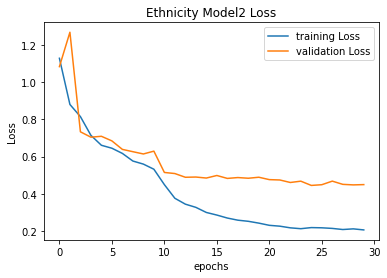

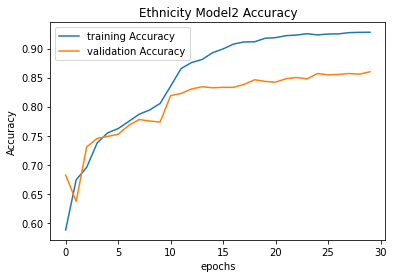

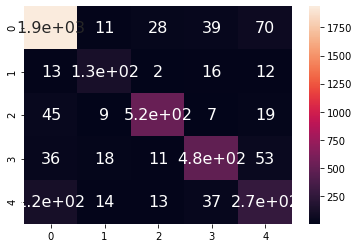

Test Precision: 0.8519701450181916 Test Recall: 0.8537832310838446 Test F1: 0.8525639579165434 Total Time: 6.1933183670043945 seconds


In [ ]:
graph_train_valid(train_loss2, valid_loss2, 'Loss', 2)
graph_train_valid(train_accuracy2, valid_accuracy2, 'Accuracy', 2)
precision2, recall2, f1_2, time2 = final_score(args2.model, device, test_loader)
print("Test Precision: {} Test Recall: {} Test F1: {} Total Time: {} seconds".format(precision2, recall2, f1_2, time2))

# Transfer Learning (Baseline)

In [21]:
class Args(object):
    pass

args3 = Args();
args3.learning_rate = 0.003
args3.regularization = 0.001

args3.train = train_loader
args3.valid = valid_loader 
args3.epochs = 30
args3.init_weight = False
args3.step = 10

In [22]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet50', pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 5)

args3.model = model
train_loss3, valid_loss3, train_accuracy3, valid_accuracy3, = train(args3)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


Adjusting learning rate of group 0 to 3.0000e-03.
Adjusting learning rate of group 0 to 3.0000e-03.
Training Loss: 1.206857683469011 Valid Loss: 1.2266609516633926 Training Accuracy: 0.5694195628166199 Valid Accuracy: 0.5809255838394165
Adjusting learning rate of group 0 to 3.0000e-03.
Training Loss: 1.137279165611033 Valid Loss: 1.1452392311969153 Training Accuracy: 0.590045154094696 Valid Accuracy: 0.5934543609619141
Adjusting learning rate of group 0 to 3.0000e-03.
Training Loss: 1.1144814405215322 Valid Loss: 1.1326561347202584 Training Accuracy: 0.603852391242981 Valid Accuracy: 0.6039376258850098
Adjusting learning rate of group 0 to 3.0000e-03.
Training Loss: 1.1103124375803781 Valid Loss: 1.297241261474192 Training Accuracy: 0.6054717302322388 Valid Accuracy: 0.6001023054122925
Adjusting learning rate of group 0 to 3.0000e-03.
Training Loss: 1.079311387674853 Valid Loss: 1.2129887971570807 Training Accuracy: 0.6157845258712769 Valid Accuracy: 0.5742776989936829
Adjusting learni

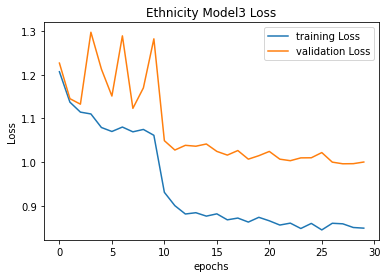

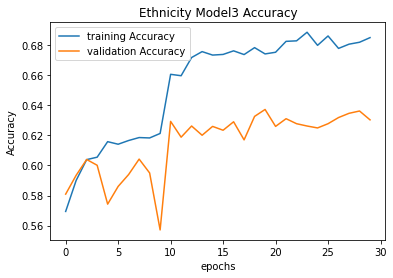

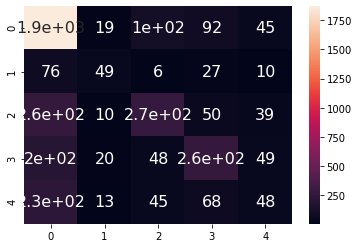

Test Precision: 0.6014751838589376 Test Recall: 0.6393149284253579 Test F1: 0.6104056013817422 Total Time: 6.186132907867432 seconds


In [23]:
device = torch.device("cuda")

graph_train_valid(train_loss3, valid_loss3, 'Loss', 3)
graph_train_valid(train_accuracy3, valid_accuracy3, 'Accuracy', 3)
precision3, recall3, f1_3, time3 = final_score(args3.model, device, test_loader)
print("Test Precision: {} Test Recall: {} Test F1: {} Total Time: {} seconds".format(precision3, recall3, f1_3, time3))